# Final presentation

Input: Lavalier microphone connected to embedded system. Saved audio files can also be used.
Processing: System workflow is as follows:

            input signal -> LPF -> DOWNSAMPLING by 2 
                                            |
                                            V
                                   FFT based convolve -> UPSAMPLE BY 2 -> LPF -> output_signal
                                            ^
                                            |
      convolution filter -> LPF -> DOWNSAMPLING by 2      
      
Low pass filtering is done in the PL logic (FPGA fabric). Upsampling and downsampling is done on the 

## 1. Import libraries

In [1]:
import wave
import numpy as np
import math
from IPython.display import Audio as IPAudio
import scipy.signal as signal
import soundfile

In [2]:
# Initialize FPGA fabric.
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

## 2. Audio input
For audio input from mic, select "option" as "line". If audio input comes from a file, select "option" as "file".

In [3]:
option = "file"
conv_filter_file = "stairs_impulse.wav"   # IMPORTANT: Select convolution filter file HERE.

In [4]:
# Configure mic.
# Sampling rate: 44.1 KHz. Mono. audio file format: wave
pAudio = base.audio
pAudio.configure(sample_rate=44100)
pAudio.set_volume(60) #max=63
pAudio.select_line_in()

In [5]:
if option == "line":
    pAudio.record(5)
    pAudio.save("mic_record.wav")
    # Convert 24 bit wav into 16 bit wav.
    data, samplerate = soundfile.read('mic_record.wav')
    soundfile.write('mic_record_16bit.wav', data, samplerate, subtype='PCM_16')
    audio_input_file = 'mic_record_16bit.wav'
elif option == "file":
    # Determine file names for audio input file.
    audio_input_file = "cello.wav"            # IMPORTANT: Select audio input file HERE.

In [6]:
# If option == "file":
# Open convolution filter file.
file = wave.open(conv_filter_file, 'rb')
# Obtain sample frequency.
sample_freq = file.getframerate()
# Obtain number of samples.
num_samples = file.getnframes()
# Get values from the signal.
signal_wave = file.readframes(num_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
# Split data into individual channels.
conv_filter = signal_array[0::2]
file.close()
# Length of audio file in seconds.
length_audio_conv_filter = math.ceil(num_samples / sample_freq)

# Open audio input file.
file = wave.open(audio_input_file, 'rb')
# Obtain sample frequency.
sample_freq = file.getframerate()
# Obtain number of samples.
num_samples = file.getnframes()
# Get values from the signal.
signal_wave = file.readframes(num_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
# Split data into individual channels.
input_signal = signal_array[0::2]
file.close()
# Length of audio file in seconds.
length_audio_input_file = math.ceil(num_samples / sample_freq)

## 3. Audio processing

In [7]:
from pynq import Overlay
from pynq import allocate

overlay = Overlay("/home/xilinx/pynq/overlays/LPF/low_pass_filter.bit")

fS = 44100  # Sampling rate.

# Python helper methods.
def apply_low_pass_filter_PS(signal, cutoff_freq):
    # Configuration.
    fL = cutoff_freq  # Cutoff frequency.
    N = 35  # Filter length.
    # Compute sinc filter.
    h = np.sinc(2 * fL / fS * (np.arange(N) - (N - 1) / 2))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Apply the low-pass filter.
    filtered_signal = np.convolve(signal, h, mode='same')
    return filtered_signal

def apply_low_pass_filter_FPGA(signal):
    # Pynq FPGA configuration:
    dma = overlay.dma         # Define DMA (Direct memory access) object.
    data_size = signal.size
    # Allocate memory in DRAM.
    input_buffer = allocate(shape=(data_size,), dtype=np.int32)
    output_buffer = allocate(shape=(data_size,), dtype=np.int32)
    # Move test signal array to DRAM storage.
    input_buffer[:] = signal 
    # Send input buffer into FPGA fabric through DMA. 
    dma.sendchannel.transfer(input_buffer)
    # Recieve data after being processed by FPGA. This process will finish when FIR module raises TLAST flag 
    # on AXI4 Stream interface.
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    # Transaction finished and save data into numpy array.
    print("FPGA: FINISHED TRANSACTION.")
    output_fromFPGA = output_buffer[:]
    return output_fromFPGA

def apply_downsampler(signal):
    # Discard every 2 samples
    downsampled_signal = signal[::2]
    return downsampled_signal

def apply_upsampler(signal):
    # Perform upsampling by inserting zeros between samples
    upsampled_signal = np.zeros(len(signal) * 2)
    upsampled_signal[::2] = signal
    return upsampled_signal

def normalize_signal(signal):
    # Normalised [-1,1]
    d = 2.*(signal - np.min(signal))/np.ptp(signal)-1
    # Normalized to 30,000
    signal = d * (2**15-1)
    return signal

In [8]:
# Decimation of input signal.
filtered_input_signal = apply_low_pass_filter_FPGA(input_signal)  # Apply LPF with Fcut=Fs/4=11025 Hz.
downsampled_input_signal = apply_downsampler(filtered_input_signal)        # Apply downsampler with M=2
# Decimation of convolution filter.
filtered_conv_filter = apply_low_pass_filter_FPGA(conv_filter)    # Apply LPF with Fcut=Fs/4=11025 Hz.
downsampled_conv_filter = apply_downsampler(filtered_conv_filter)          # Apply downsampler with M=2

FPGA: FINISHED TRANSACTION.
FPGA: FINISHED TRANSACTION.


In [9]:
# FIR filtering: FFT based convolution for input signal and convolution filter.
output_signal = signal.fftconvolve(downsampled_input_signal, downsampled_conv_filter)

In [10]:
# Apply upsampling of output signal to 44.1 KHz.
upsampled_output_signal = apply_upsampler(output_signal)
# Apply LPF to avoid aliasing.
upsampled_output_signal = apply_low_pass_filter_FPGA(upsampled_output_signal)
# Perform audio normalization.
final_output_signal = normalize_signal(upsampled_output_signal)

FPGA: FINISHED TRANSACTION.


In [11]:
# Save final output signal as wav file in SD card.
from scipy.io.wavfile import write
scaled = np.int16(final_output_signal / np.max(np.abs(final_output_signal)) * 32767)
write('processed_audio_16bit.wav', fS, scaled)

## 4. Audio output

### Play audios in PC.

In [12]:
# Play input sound
IPAudio(input_signal, rate=44100)

In [13]:
# Play impulse response
IPAudio(conv_filter, rate=44100)

In [14]:
# Play output sound
IPAudio(final_output_signal, rate=44100)

## 5. Audio plots

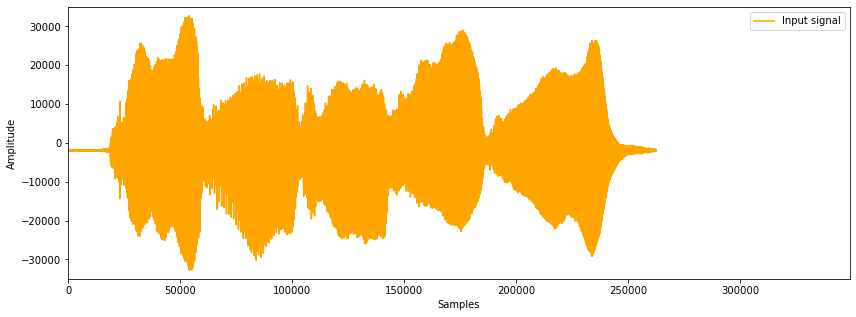

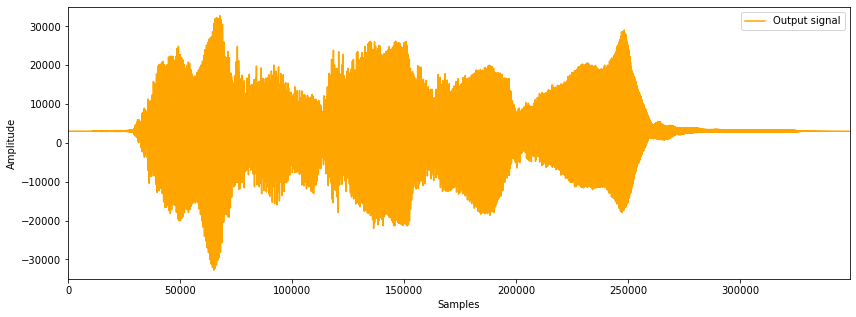

In [15]:
import matplotlib.pyplot as plt

# Original
fig, ax = plt.subplots(figsize=(14,5))          # Plotting graph
ax.plot(normalize_signal(input_signal), label='Input signal', color="orange")
# Set labels and legends
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_xlim([0, final_output_signal.size])
ax.set_ylim([-35000, 35000])
# Show the plot
plt.show()

# Output sound
fig, ax = plt.subplots(figsize=(14,5))          # Plotting graph
ax.plot(final_output_signal, label='Output signal', color="orange")
# Set labels and legends
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_xlim([0, final_output_signal.size])
ax.set_ylim([-35000, 35000])
# Show the plot
plt.show()
